# Notebook to run hub ingestion using lake tables
##### The notebook will load match flows, score cards etc

### Assumptions
- Ideally we should be doing incremental loads fetching new data since the last lake load using watermark, but in this example we will doing full load everytime.
- We should have versioning logic to support Type 2 SCD using metadata columns like records version and record sha, but in this since we will be doing full load everytime we skipping this.

In [1]:
# %%configure
# {
#     "--datalake-formats":"delta",
#     "--conf":"spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension --conf spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog"
# }

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 0.37.3 


In [6]:
%idle_timeout 200
%glue_version 3.0
%worker_type G.1X
%number_of_workers 2

Current idle_timeout is 2800 minutes.
idle_timeout has been set to 200 minutes.
Setting Glue version to: 3.0
Previous worker type: G.1X
Setting new worker type to: G.1X
Previous number of workers: 5
Setting new number of workers to: 2


In [1]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

import boto3

sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

Authenticating with environment variables and user-defined glue_role_arn: arn:aws:iam::687003041478:role/orka-glue-role
Trying to create a Glue session for the kernel.
Worker Type: G.1X
Number of Workers: 2
Session ID: faa9da1b-7918-4fa0-9a9d-0d4ef2da36ca
Job Type: glueetl
Applying the following default arguments:
--glue_kernel_version 0.37.3
--enable-glue-datacatalog true
Waiting for session faa9da1b-7918-4fa0-9a9d-0d4ef2da36ca to get into ready status...
Session faa9da1b-7918-4fa0-9a9d-0d4ef2da36ca has been created.



In [2]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [25]:
# Create a Glue client
glue_client = boto3.client('glue')

# Variables

In [26]:
# Crawler IAM role ARN
crawler_role = 'arn:aws:iam::687003041478:role/orka-glue-role'  # Replace with your IAM role ARN

# DB variables
bronze_database_name = "orka_warehouse_bronze" # Specify the lake/bronze glue catalog database name

# Target Player info table
player_info_table_name = "player_info" # Specify player info target table name in lake
# Target Deliveries table
deliveries_table_name = "deliveries"
# Target matches table
matches_table_name = "matches"

# Specify the hub target database name
hub_database_name = 'orka_warehouse_silver'

### Utility functions

In [29]:
def crawl_tables(glue_client, df_dic, data_loc, database_name):
    """Crawler to crawl tables stored in s3 after processing
    @param: glue_client Our glue client
    @param: df_dic dictionary containing mapping of dataframe name and dataframe object
    @param: data_loc Database location
    @param: database_name Name of database in glue catalog where data is to be loaded
    """
    for table, data_df in df_dic.items():
        crawler_name = f"{table}_crwl"
        # Specify the S3 target for the crawler
        s3_target_path = f"{data_loc}/{table}"

        # Create the crawler
        response = glue_client.create_crawler(
            Name=crawler_name,
            Role=crawler_role,
            Targets={
                'S3Targets': [
                    {
                        'Path': s3_target_path
                    }
                ]
            },
            DatabaseName= database_name,
            SchemaChangePolicy={
                'UpdateBehavior': 'UPDATE_IN_DATABASE',
                'DeleteBehavior': 'DEPRECATE_IN_DATABASE'
            }
        )

        # Start the crawler
        glue_client.start_crawler(Name=crawler_name)
        

def load_tables(df_dic,data_loc):
    """Function to load dataframes in dictionary to s3
    @param: df_dic dictionary containing mapping of dataframe name and dataframe object
    @param: data_loc Database location
    """
    for table, data_df in df_dic.items():
        data_df.write.format("parquet").mode("overwrite").save(f"{data_loc}/{table}")

### Loading required lake tables to be used as source for hub ingestion

#### Loading deliveries

In [11]:
deliveries_dyf = glueContext.create_dynamic_frame.from_catalog(database=bronze_database_name, table_name=deliveries_table_name)
deliveries_df = deliveries_dyf.toDF()
deliveries_df.show()

+--------+------+--------------------+--------------------+----+----+--------------+----------------+---------------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+---------+
|match_id|inning|        batting_team|        bowling_team|over|ball|       batsman|     non_striker|         bowler|is_super_over|wide_runs|bye_runs|legbye_runs|noball_runs|penalty_runs|batsman_runs|extra_runs|total_runs|player_dismissed|dismissal_kind|  fielder|
+--------+------+--------------------+--------------------+----+----+--------------+----------------+---------------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+---------+
|     457|     2| Chennai Super Kings|      Mumbai Indians|   4|   1|       M Vijay|        DJ Bravo|     MG Johnson|            0|        0|       0|          0|          0|           0|           0|     

#### Loading player info

In [6]:
player_info_dyf = glueContext.create_dynamic_frame.from_catalog(database=bronze_database_name, table_name=player_info_table_name)
player_info_df = player_info_dyf.toDF()
player_info_df.show(2)

+-----+------+-------------+---------+--------------------+---------+----------+-----+-------------+---+--------------------+-------------+--------------------+-----+------+-----------------+------------------+----------------+------------------+----------------+-----------------+----------------+----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+---------------+-----------------+---------------+----------------+---------------+---------------+----------------+---------------+---------------+---------------+---------------+---------------+-----------------+------------------+----------------+------------------+----------------+-----------------+----------------+----------------+-----------------+----------------+----------------+----------------+----------------+----------------+-----------------------+------------------------+----------------------+------------------------+---------

#### Loading matches

In [7]:
matches_dyf = glueContext.create_dynamic_frame.from_catalog(database=bronze_database_name, table_name=matches_table_name)
matches_df = matches_dyf.toDF()
matches_df.show(2)

+-------------+---------------+---------+---------------+-------+--------+------+---------------+--------------+-----------+----------+-----------+---+----------+---------------+-------------------+--------------------+-------------------+
|toss_decision|         winner|     city|player_of_match|umpire3|  Season|result|        umpire2|win_by_wickets|win_by_runs|dl_applied|    umpire1| id|      date|          team1|              team2|               venue|        toss_winner|
+-------------+---------------+---------+---------------+-------+--------+------+---------------+--------------+-----------+----------+-----------+---+----------+---------------+-------------------+--------------------+-------------------+
|        field|Kings XI Punjab|  Chennai|       J Theron|       |IPL-2010|   tie|      DJ Harper|             0|          0|         0|K Hariharan|190|21-03-2010|Kings XI Punjab|Chennai Super Kings|MA Chidambaram St...|Chennai Super Kings|
|          bat|Deccan Chargers|Centurion

## Building silver tables

#### Calculating extra fields

In [12]:
# is the ball countable
deliveries_df = deliveries_df.withColumn("is_real_ball", when((col("wide_runs") == 0) & (col("noball_runs") == 0), 1).otherwise(0))

#### Crating temp views

In [14]:
deliveries_df.createOrReplaceTempView('deliveries')

In [30]:
matches_df.createOrReplaceTempView('matches')

### Building match flow

#### Match flow inning stat

In [17]:
# Powerplay calculation
inning_win = Window.partitionBy("match_id", "inning")

match_flow_df_inning = deliveries_df.withColumn("powerplay_run", when(col("over") <=6, col("total_runs")).otherwise(0))\
    .withColumn("powerplay_wicket", when((col("over") <=6) & (col("player_dismissed").isNotNull()), 1).otherwise(0))\
    .withColumn("total_powerplay_run", sum("powerplay_run").over(inning_win))\
    .withColumn("total_powerplay_wicket", sum("powerplay_wicket").over(inning_win))



def calculate_balls_by_x_runs(match_flow_df_inning, run):
    # Runs after number of balls calculation
    inning_over_ball_win = Window.partitionBy("match_id", "inning").orderBy("over","ball")
    over_run_win = Window.partitionBy("match_id", "inning", f"over_{run}_flag")

    match_flow_df_inning = match_flow_df_inning.withColumn("cumulative_runs", sum(col("total_runs")).over(inning_over_ball_win))\
        .withColumn("cumulative_balls", sum(col("is_real_ball")).over(inning_over_ball_win))\
        .withColumn(f"over_{run}_flag", when(col("cumulative_runs") >=run, 1).otherwise(lit(None)))\
        .withColumn(f"cumulative_balls_{run}", when(col("cumulative_runs") >=run, col("cumulative_balls")).otherwise(lit(None)))\
        .withColumn(f"{run}_in_balls", min(col(f"cumulative_balls_{run}")).over(over_run_win))\
        .withColumn(f"{run}_in_balls", min(col(f"{run}_in_balls")).over(over_run_win))\
        .withColumn(f"{run}_in_balls", last(col(f"{run}_in_balls"), ignorenulls=True).over(inning_win))
    
    return match_flow_df_inning

match_flow_df_inning = calculate_balls_by_x_runs(match_flow_df_inning, 50)
match_flow_df_inning = calculate_balls_by_x_runs(match_flow_df_inning, 100)
match_flow_df_inning = calculate_balls_by_x_runs(match_flow_df_inning, 150)
match_flow_df_inning = calculate_balls_by_x_runs(match_flow_df_inning, 200)
match_flow_df_inning = calculate_balls_by_x_runs(match_flow_df_inning, 250)

match_flow_df_inning = match_flow_df_inning.select("match_id","inning","batting_team","bowling_team","total_powerplay_run","total_powerplay_wicket","50_in_balls","100_in_balls","150_in_balls","200_in_balls","250_in_balls")\
                        .dropDuplicates()

match_flow_df_inning.filter("match_id=1").show()

+--------+------+--------------------+--------------------+-------------------+----------------------+-----------+------------+------------+------------+------------+
|match_id|inning|        batting_team|        bowling_team|total_powerplay_run|total_powerplay_wicket|50_in_balls|100_in_balls|150_in_balls|200_in_balls|250_in_balls|
+--------+------+--------------------+--------------------+-------------------+----------------------+-----------+------------+------------+------------+------------+
|       1|     2|Royal Challengers...| Sunrisers Hyderabad|                 54|                     1|         32|          61|          95|        null|        null|
|       1|     1| Sunrisers Hyderabad|Royal Challengers...|                 59|                     1|         32|          69|          89|         118|        null|
+--------+------+--------------------+--------------------+-------------------+----------------------+-----------+------------+------------+------------+------------

#### Match flow batsman stat

In [20]:
def calculate_balls_by_x_batsman_runs(match_flow_df_batsman_stats, run):
    # Runs after number of balls calculation
    inning_batsman_over_ball_win = Window.partitionBy("match_id", "inning", "batsman").orderBy("over","ball")
    over_run_win = Window.partitionBy("match_id", "inning", "batsman", f"over_{run}_flag")

    match_flow_df_batsman_stats = match_flow_df_batsman_stats.withColumn("cumulative_batsman_runs", sum(col("batsman_runs")).over(inning_batsman_over_ball_win))\
        .withColumn("cumulative_batsman_balls", sum(col("is_real_ball")).over(inning_batsman_over_ball_win))\
        .withColumn(f"over_{run}_flag", when(col("cumulative_batsman_runs") >=run, 1).otherwise(lit(None)))\
        .withColumn(f"cumulative_batsman_balls_{run}", when(col("cumulative_batsman_runs") >=run, col("cumulative_batsman_balls")).otherwise(lit(None)))\
        .withColumn(f"batsman_{run}_in_balls", min(col(f"cumulative_batsman_balls_{run}")).over(over_run_win))
    
    return match_flow_df_batsman_stats

match_flow_df_batsman_stats = calculate_balls_by_x_batsman_runs(deliveries_df, 50)
match_flow_df_batsman_stats = calculate_balls_by_x_batsman_runs(match_flow_df_batsman_stats, 100)
match_flow_df_batsman_stats = calculate_balls_by_x_batsman_runs(match_flow_df_batsman_stats, 150)
match_flow_df_batsman_stats = calculate_balls_by_x_batsman_runs(match_flow_df_batsman_stats, 200)
match_flow_df_batsman_stats = calculate_balls_by_x_batsman_runs(match_flow_df_batsman_stats, 250)

match_flow_df_batsman_stats = match_flow_df_batsman_stats.filter("coalesce(batsman_50_in_balls,batsman_100_in_balls,batsman_150_in_balls,batsman_200_in_balls,batsman_250_in_balls) is not null")

match_flow_df_batsman_stats = match_flow_df_batsman_stats.select("match_id", "inning", "batsman","batsman_50_in_balls","batsman_100_in_balls","batsman_150_in_balls","batsman_200_in_balls","batsman_250_in_balls")\
                                .dropDuplicates()

match_flow_df_batsman_stats.filter("match_id=1").show()

+--------+------+------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|match_id|inning|     batsman|batsman_50_in_balls|batsman_100_in_balls|batsman_150_in_balls|batsman_200_in_balls|batsman_250_in_balls|
+--------+------+------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|       1|     1|MC Henriques|                 34|                null|                null|                null|                null|
|       1|     1|Yuvraj Singh|                 23|                null|                null|                null|                null|
+--------+------+------------+-------------------+--------------------+--------------------+--------------------+--------------------+


#### Match flow wicket partnership stat

In [21]:
def calculate_wicket_partner_by_x_runs(match_flow_df_inning_wicket, run):
    # Runs after number of balls calculation
    inning_over_ball_win = Window.partitionBy("match_id", "inning").orderBy("over","ball")
    inning_over_wicket_win = Window.partitionBy("match_id", "inning", "cumulative_player_dismissed").orderBy("over","ball")
    over_run_win = Window.partitionBy("match_id", "inning", "cumulative_player_dismissed", f"over_{run}_flag")

    match_flow_df_inning_wicket = match_flow_df_inning_wicket.withColumn("cumulative_player_dismissed", count(col("player_dismissed")).over(inning_over_ball_win))\
        .withColumn("cumulative_player_dismissed", when(col("cumulative_player_dismissed").isNull(),0).otherwise(col("cumulative_player_dismissed")))\
        .withColumn("cumulative_wicket_balls", sum(col("is_real_ball")).over(inning_over_wicket_win))\
        .withColumn("cumulative_wicket_runs", sum(col("total_runs")).over(inning_over_wicket_win))\
        .withColumn(f"over_{run}_flag", when(col("cumulative_wicket_runs") >=run, 1).otherwise(lit(None)))\
        .withColumn(f"cumulative_wicket_balls_{run}", when(col("cumulative_wicket_runs") >=run, col("cumulative_wicket_balls")).otherwise(lit(None)))\
        .withColumn(f"wicket_{run}_in_balls", min(col(f"cumulative_wicket_balls_{run}")).over(over_run_win))
    
    
    return match_flow_df_inning_wicket

match_flow_df_inning_wicket = calculate_wicket_partner_by_x_runs(deliveries_df, 50)

match_flow_df_inning_wicket = match_flow_df_inning_wicket.withColumn("batting_pair", sort_array(array("batsman", "non_striker")))
match_flow_df_inning_wicket = match_flow_df_inning_wicket.select("match_id","inning",col("batting_pair")[0].alias("batsman_1"), col("batting_pair")[1].alias("batsman_2"),"cumulative_player_dismissed","wicket_50_in_balls")\
                                .filter("wicket_50_in_balls is not null")\
                                .dropDuplicates()

match_flow_df_inning_wicket.filter("match_id=1").show()

+--------+------+------------+-------------+---------------------------+------------------+
|match_id|inning|   batsman_1|    batsman_2|cumulative_player_dismissed|wicket_50_in_balls|
+--------+------+------------+-------------+---------------------------+------------------+
|       1|     2|    CH Gayle|Mandeep Singh|                          0|                32|
|       1|     2|   KM Jadhav|      TM Head|                          2|                27|
|       1|     1|MC Henriques|     S Dhawan|                          1|                37|
|       1|     1|MC Henriques| Yuvraj Singh|                          2|                25|
+--------+------+------------+-------------+---------------------------+------------------+


## Score cards

#### Batting score card

In [22]:
battin_scorecard_df = spark.sql("""with bs as (
select distinct match_id, batting_team, batsman, 
sum(total_runs) over(partition by match_id, batting_team) runs, 
count(1) over(partition by match_id, batting_team)  total_balls, 
count(player_dismissed) over(partition by match_id, batting_team) wickets,
sum(total_runs) over(partition by match_id, batting_team, batsman) player_runs, 
count(1) over(partition by match_id, batting_team, batsman) player_balls,  
sum(case when total_runs=4 then 1 else 0 end) over(partition by match_id, batting_team, batsman) fours,
sum(case when total_runs=6 then 1 else 0 end) over(partition by match_id, batting_team, batsman) sixes
from deliveries where match_id =1
) 
select distinct *, round(player_runs/player_balls*100,2) sr, round(runs/total_balls*100,2) rr from bs
""")

battin_scorecard_df.filter("match_id=1").show()

+--------+--------------------+-------------+----+-----------+-------+-----------+------------+-----+-----+------+------+
|match_id|        batting_team|      batsman|runs|total_balls|wickets|player_runs|player_balls|fours|sixes|    sr|    rr|
+--------+--------------------+-------------+----+-----------+-------+-----------+------------+-----+-----+------+------+
|       1| Sunrisers Hyderabad|  BCJ Cutting| 207|        125|      4|         16|           6|    0|    2|266.67| 165.6|
|       1| Sunrisers Hyderabad|    DA Warner| 207|        125|      4|         17|           9|    2|    1|188.89| 165.6|
|       1| Sunrisers Hyderabad|     DJ Hooda| 207|        125|      4|         16|          12|    0|    1|133.33| 165.6|
|       1| Sunrisers Hyderabad| MC Henriques| 207|        125|      4|         52|          37|    3|    2|140.54| 165.6|
|       1| Sunrisers Hyderabad|     S Dhawan| 207|        125|      4|         41|          31|    5|    0|132.26| 165.6|
|       1| Sunrisers Hyd

In [23]:
bowling_scorecard_df = spark.sql("""with bs as (
select distinct match_id, bowling_team, bowler,
concat(cast(floor(count(1) over(partition by match_id, bowling_team, bowler)/6) as string),'.',cast(mod(count(1) over(partition by match_id, bowling_team, bowler),6) as string)) overs,
sum(total_runs) over(partition by match_id, bowling_team, bowler) runs,
case when sum(total_runs) over(partition by match_id, bowling_team, bowler, `over`) >= 1 then 0 else 1 end maiden,
count(player_dismissed) over(partition by match_id, bowling_team, bowler) wickets,
sum(case when total_runs=4 then 1 else 0 end) over(partition by match_id, bowling_team, bowler) fours,
sum(case when total_runs=6 then 1 else 0 end) over(partition by match_id, bowling_team, bowler) sixes,
sum(case when total_runs=0 then 1 else 0 end) over(partition by match_id, bowling_team, bowler) zeros,
sum(case when wide_runs>0 then 1 else 0 end) over(partition by match_id, bowling_team, bowler) wides,
sum(case when noball_runs>0 then 1 else 0 end) over(partition by match_id, bowling_team, bowler) noballs
from deliveries where match_id=1)
select distinct *, round(runs/overs,2) economy from bs
""")

bowling_scorecard_df.filter("match_id=1").show()

+--------+--------------------+------------+-----+----+------+-------+-----+-----+-----+-----+-------+-------+
|match_id|        bowling_team|      bowler|overs|runs|maiden|wickets|fours|sixes|zeros|wides|noballs|economy|
+--------+--------------------+------------+-----+----+------+-------+-----+-----+-----+-----+-------+-------+
|       1|Royal Challengers...| A Choudhary|  4.4|  55|     0|      1|    5|    3|    5|    3|      1|   12.5|
|       1|Royal Challengers...|    TS Mills|  4.1|  32|     0|      1|    3|    1|   10|    1|      0|    7.8|
|       1|Royal Challengers...|   YS Chahal|  4.0|  22|     0|      1|    0|    0|    5|    0|      0|    5.5|
|       1|Royal Challengers...|   STR Binny|  1.0|  10|     0|      1|    1|    0|    1|    0|      0|   10.0|
|       1| Sunrisers Hyderabad|     A Nehra|  4.1|  42|     0|      2|    6|    1|    8|    1|      0|  10.24|
|       1| Sunrisers Hyderabad|MC Henriques|  2.1|  20|     0|      1|    2|    0|    1|    0|      1|   9.52|
|

In [50]:
points_table_df = spark.sql("select distinct season, winner as team, count(1) as points from matches group by season, winner")
points_table_df.show()

+--------+--------------------+------+
|  season|                team|points|
+--------+--------------------+------+
|IPL-2011| Chennai Super Kings|    11|
|IPL-2011|    Rajasthan Royals|     6|
|IPL-2016| Sunrisers Hyderabad|    11|
|IPL-2008|     Kings XI Punjab|    10|
|IPL-2011|Kochi Tuskers Kerala|     6|
|IPL-2015|Royal Challengers...|     8|
|IPL-2013|     Kings XI Punjab|     8|
|IPL-2014|     Kings XI Punjab|    12|
|IPL-2008|      Mumbai Indians|     7|
|IPL-2010|Royal Challengers...|     8|
|IPL-2008|    Rajasthan Royals|    13|
|IPL-2011|Kolkata Knight Ri...|     8|
|IPL-2013| Sunrisers Hyderabad|    10|
|IPL-2010|      Mumbai Indians|    11|
|IPL-2017|Rising Pune Super...|    10|
|IPL-2010|    Delhi Daredevils|     7|
|IPL-2013|      Mumbai Indians|    13|
|IPL-2019| Chennai Super Kings|    10|
|IPL-2011|Royal Challengers...|    10|
|IPL-2018|    Delhi Daredevils|     5|
+--------+--------------------+------+
only showing top 20 rows


### Match details

In [41]:
match_details_df = spark.sql("""select venue, team1, team2, toss_decision, season, player_of_match, date, 
                        concat_ws(', ', umpire1, umpire2, umpire3) as umpires,
                        winner
                        from matches 
                    """)
match_details_df.filter("season='IPL-2017' and date='15-04-2017'").show()

+----------------+--------------------+-------------------+-------------+--------+---------------+----------+--------------------+--------------------+
|           venue|               team1|              team2|toss_decision|  season|player_of_match|      date|             umpires|              winner|
+----------------+--------------------+-------------------+-------------+--------+---------------+----------+--------------------+--------------------+
|    Eden Gardens|Kolkata Knight Ri...|Sunrisers Hyderabad|        field|IPL-2017|     RV Uthappa|15-04-2017|AY Dandekar, NJ L...|Kolkata Knight Ri...|
|Feroz Shah Kotla|    Delhi Daredevils|    Kings XI Punjab|          bat|IPL-2017|    CJ Anderson|15-04-2017|YC Barde, Nitin M...|    Delhi Daredevils|
+----------------+--------------------+-------------------+-------------+--------+---------------+----------+--------------------+--------------------+


# Writing result dataframes to lake

Loading all the tables

In [49]:
# Building map for crawler and loader functions
match_flow_silver_tables_to_load = {"match_flow_inning":match_flow_df_inning,
                                    "match_flow_batsman_stats":match_flow_df_batsman_stats,
                                    "match_flow_inning_wicket_partnership":match_flow_df_inning_wicket,
                                    "batting_scorecard":battin_scorecard_df,
                                    "bowling_scorecard":bowling_scorecard_df,
                                    "points_table":points_table_df,
                                    "match_details":match_details_df
                                   }

load_tables(match_flow_silver_tables_to_load,hub_loc)
crawl_tables(glue_client, match_flow_silver_tables_to_load, hub_loc, hub_database_name)

# *****************************************************
# Now that hub is loaded, lets look at results in ATHENA
# *****************************************************

## Looking at loaded databases and tables in glue catalog

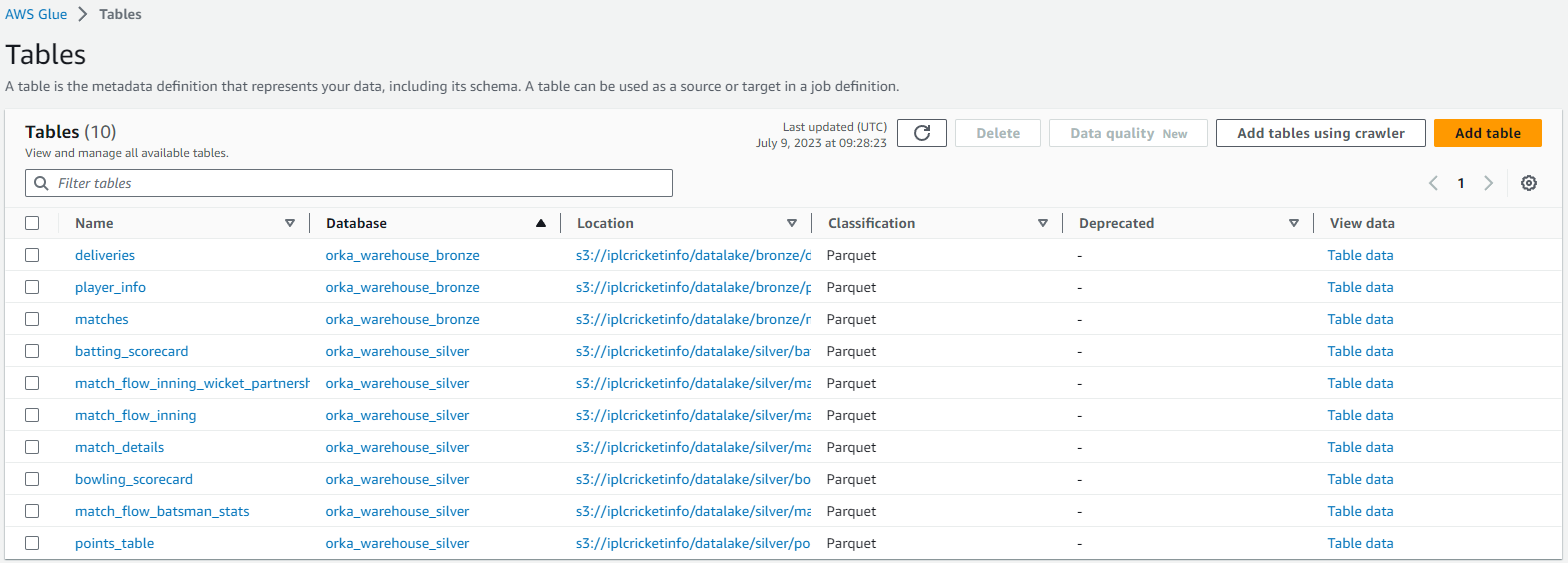

## Looking at crawlers created

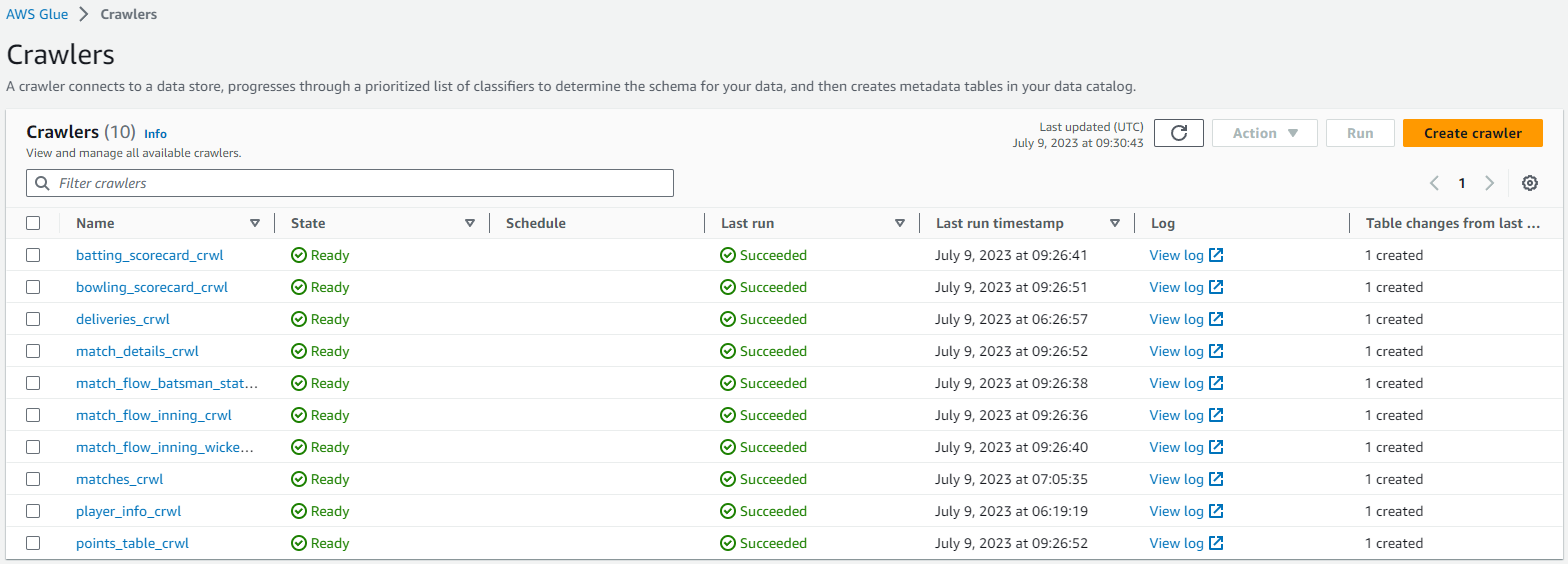

## Looking at external s3 location of lake 
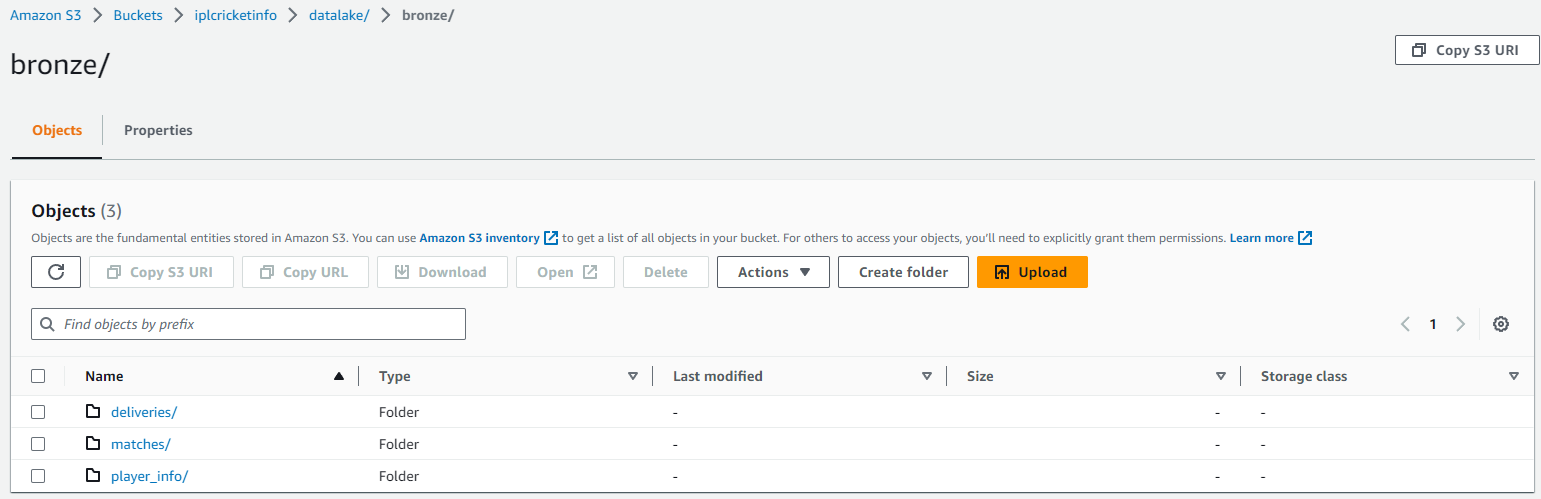

## Looking at external s3 location of lake

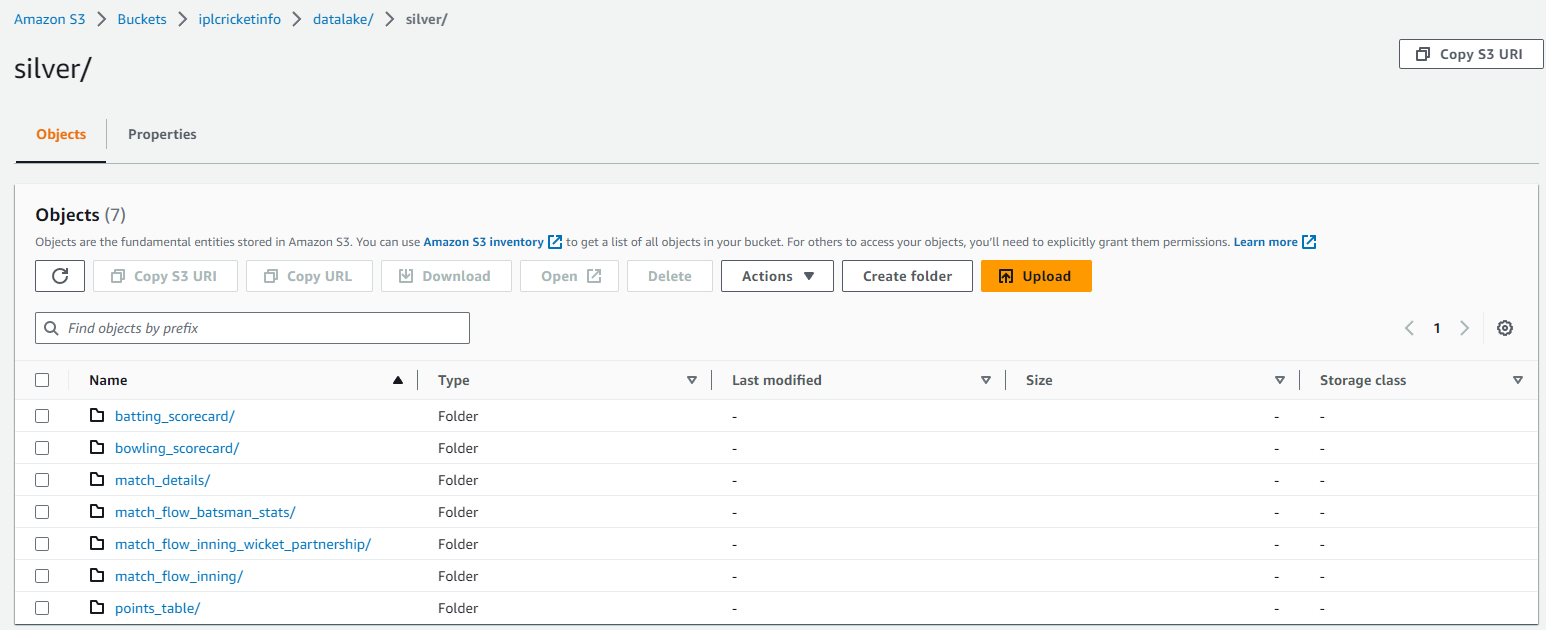

# Looking at athena result for a match and comparing it with results from [espn page](https://www.espncricinfo.com/series/ipl-2017-1078425/sunrisers-hyderabad-vs-royal-challengers-bangalore-1st-match-1082591/full-scorecard)

## Batting score card

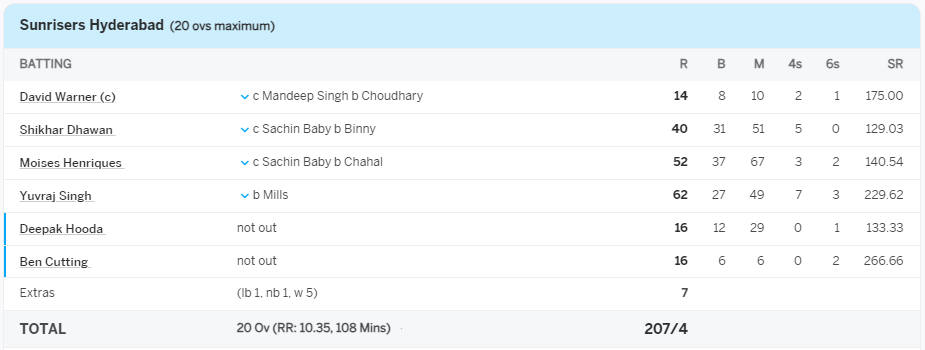

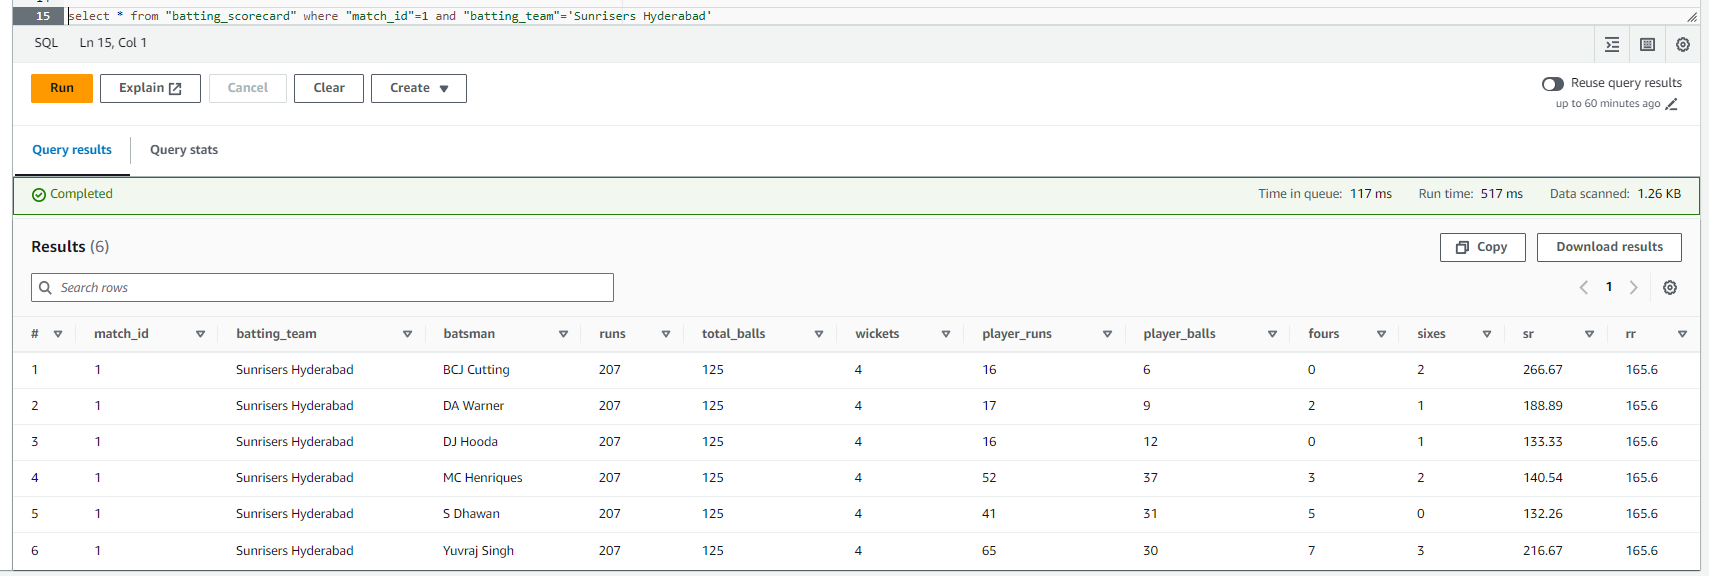

There's minor discrepencies in total_balls, player_runs due to extras(No's, Wide's, Bye's) being counted which I didn't correct.

## Bowling score card

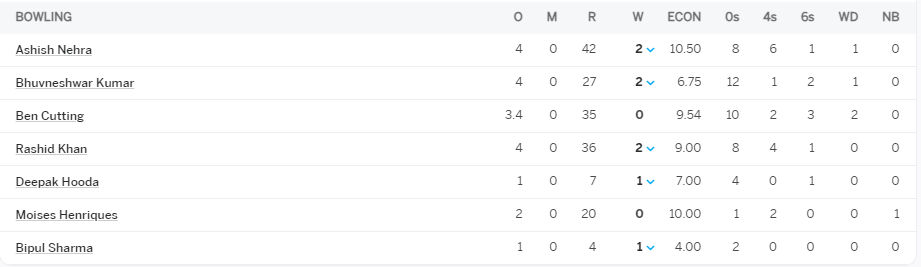

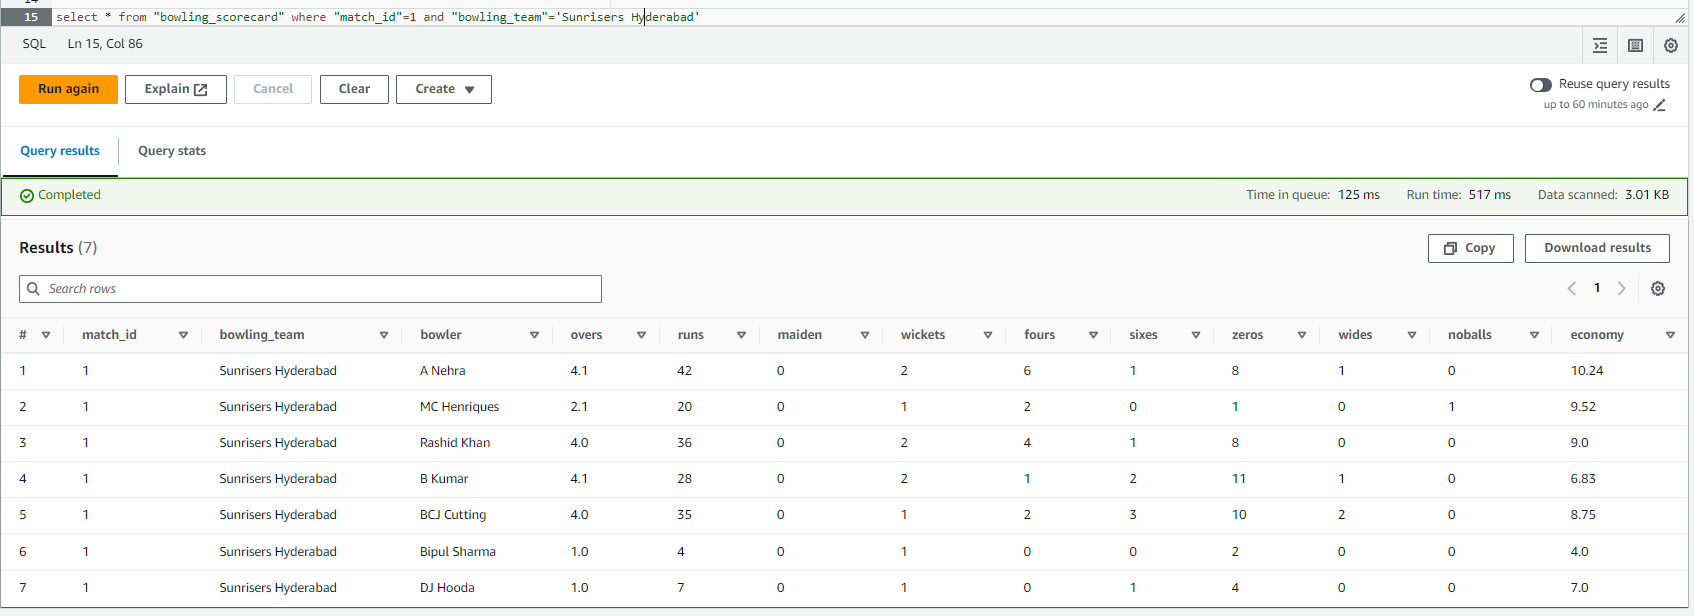

Here too there is minor discrepency in overs, due to extras(No's, Wide's, Bye's) being counted which I didn't correct.

## Match details

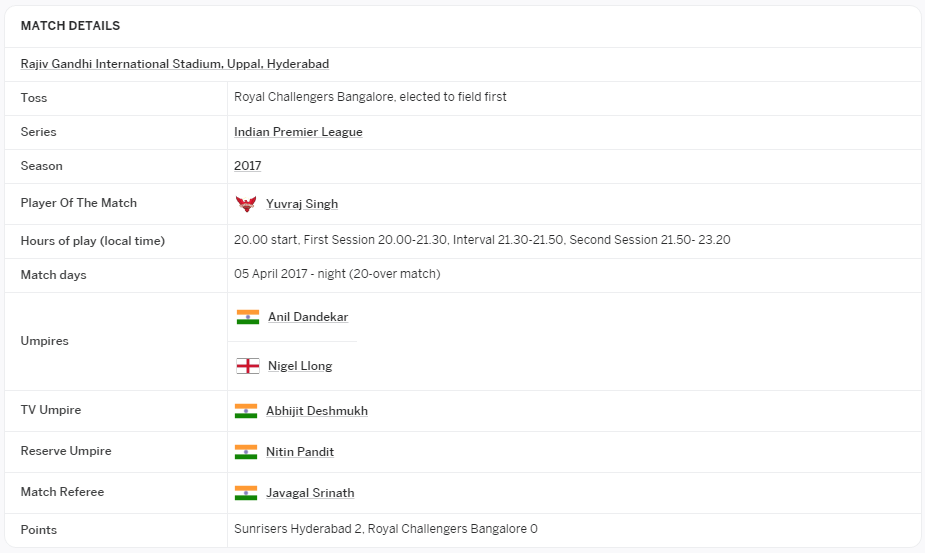

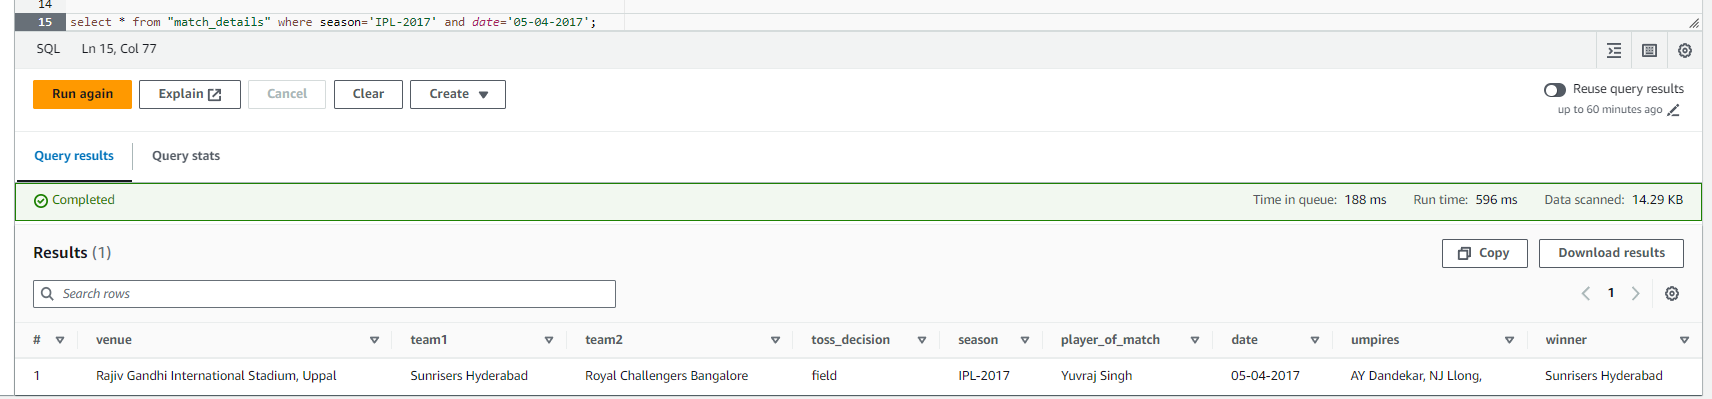

## Match flow stats

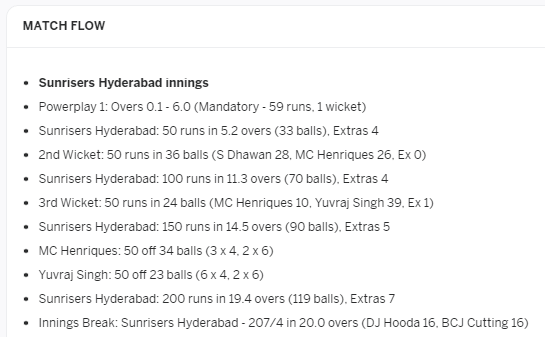

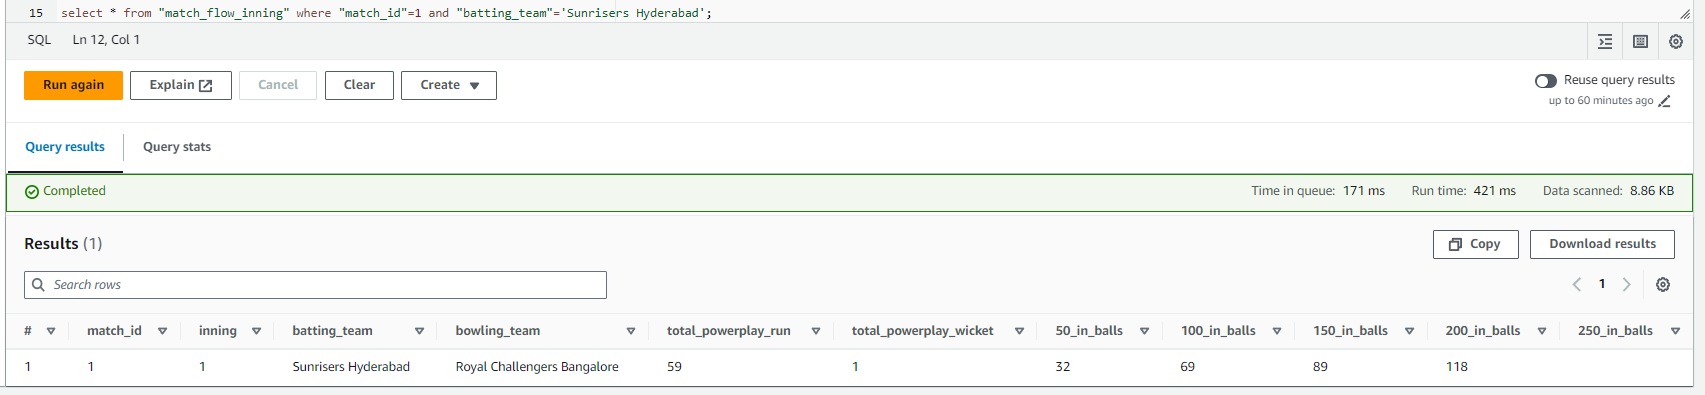

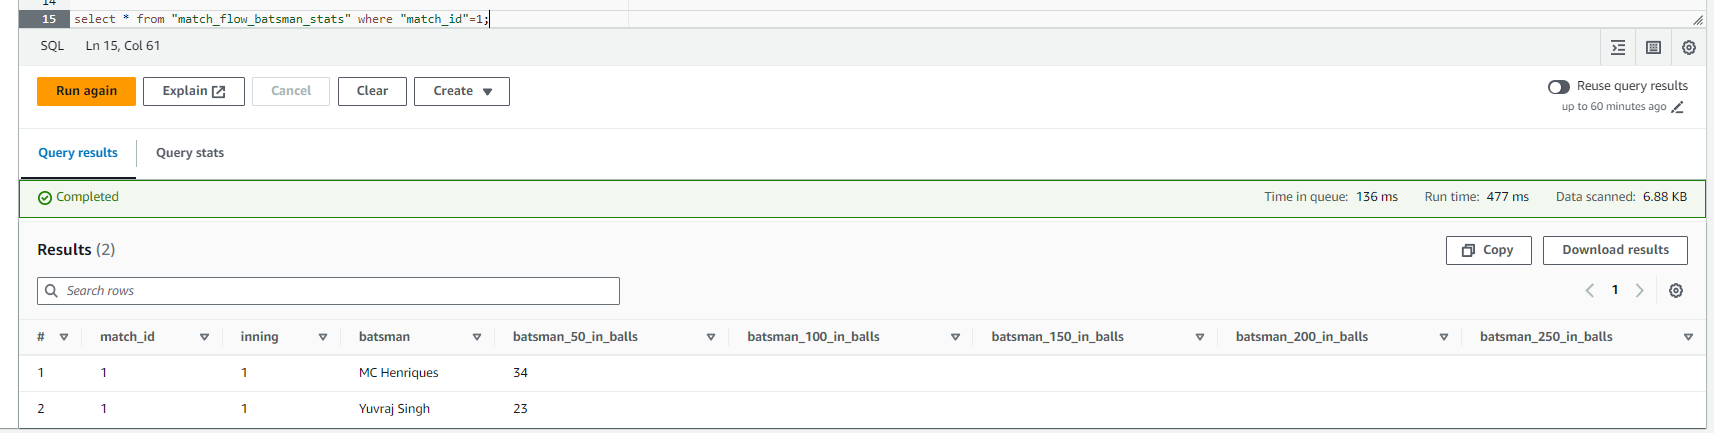

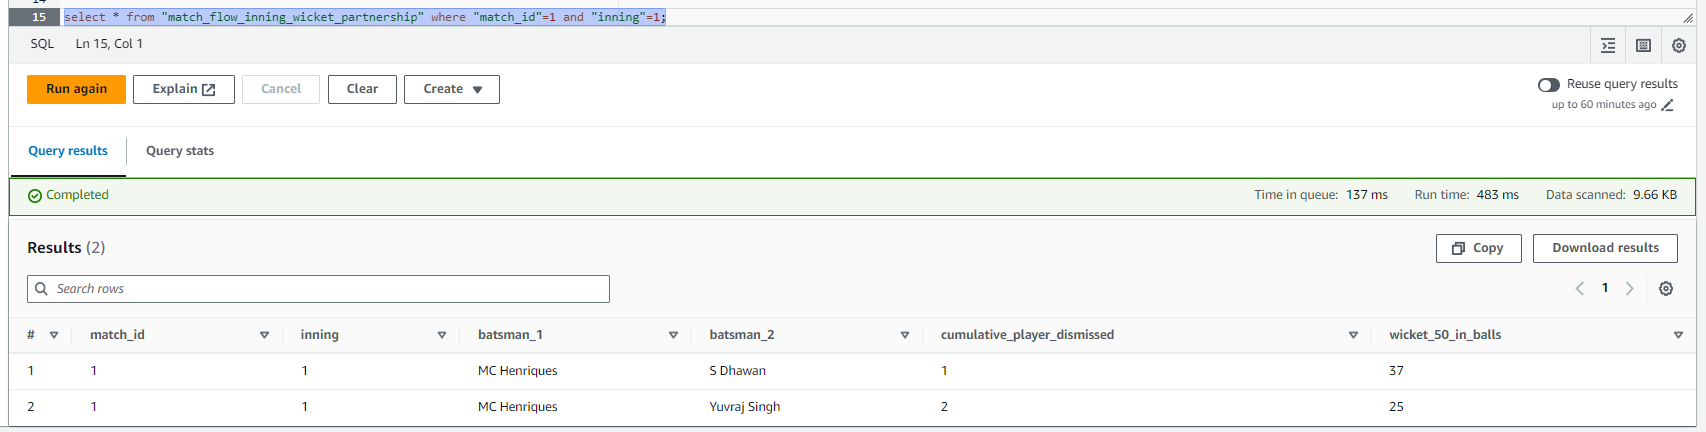

## Points table

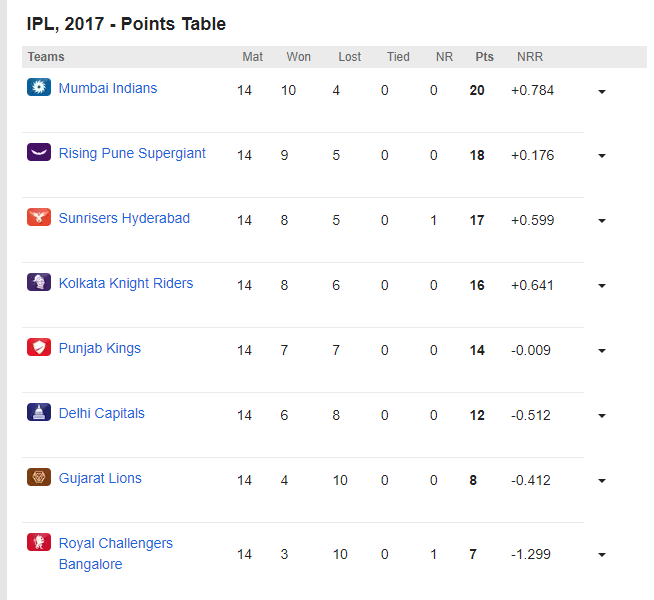

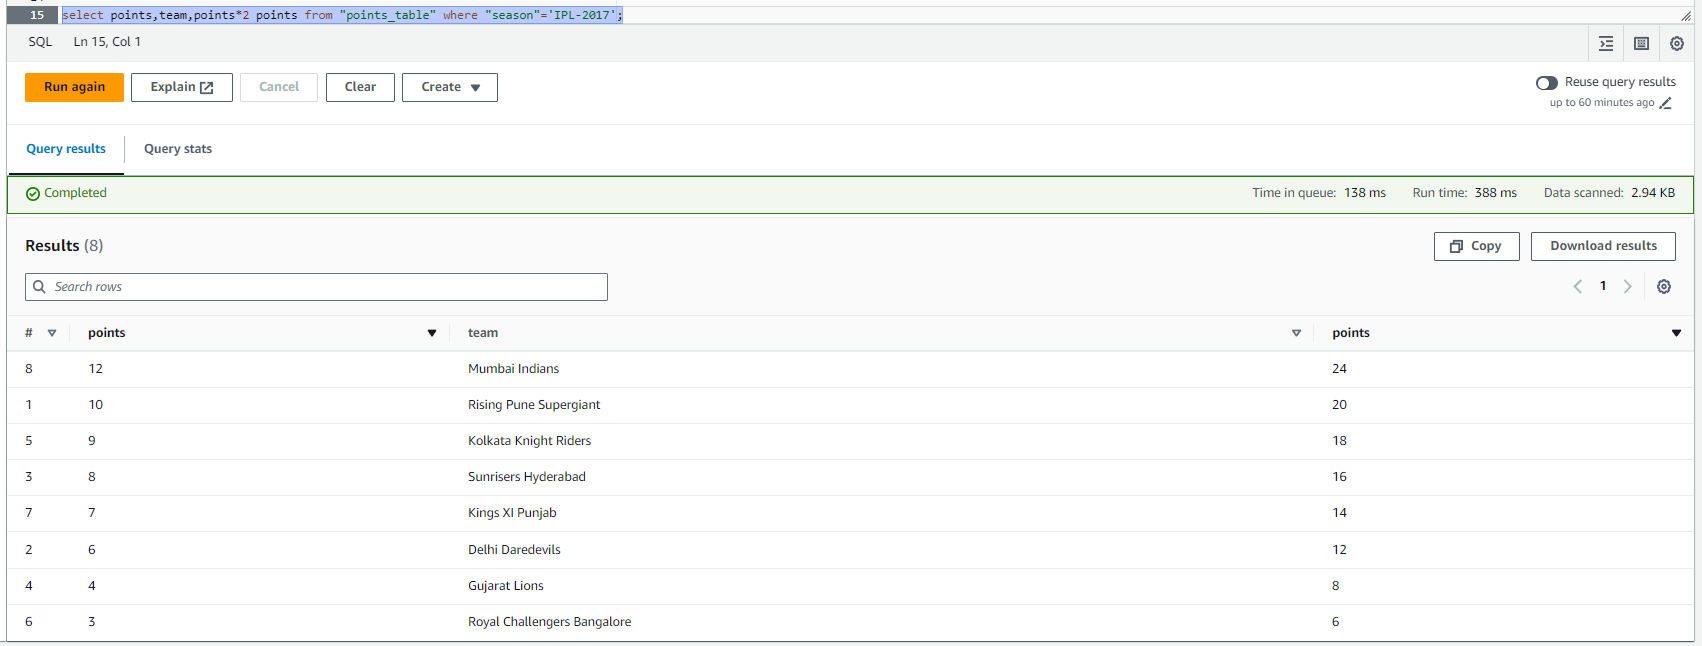

Here, there is dicrepancy because qualifier matches are getting counted toward points which I didn't correct.

## Finishing up

In [52]:
job.commit()